In [3]:
import pdb, os, pickle,json 
import math 
import random
import pandas as pd
import numpy as np 
from scipy.stats import ttest_rel,ttest_ind, ttest_1samp 
from matplotlib import pyplot as plt 
import seaborn as sns 
from sklearn.metrics import adjusted_rand_score 
import requests
# humanUtils
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/humanUtils.py")
with open('humanUtils.py', 'w') as f:
    f.write(r.text)
from humanUtils import * 
# analysis
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/analysis.py")
with open('analysis.py', 'w') as f:
    f.write(r.text)
from analysis import *
# utils 
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/utils.py")
with open('utils.py', 'w') as f:
    f.write(r.text)
from utils import * 
%load_ext autoreload
%autoreload 2
sns.set_context('talk')
%matplotlib inline
plt.rcParams['font.size'] = 22
condL = ['blocked','interleaved','early','middle','late']
ns=50
unique_num = random.uniform(0, 1e4)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# run simulations 1 through 4 from the paper and save data (simulation 3 variant with results displayed in Figure S4 is called simulation 4 here)

In [4]:
model_acc_df_list = []
model_states_df_list = []
for sim_name in ["sim1", "sim2", "sim3", "sim4"]:
  print(sim_name)
  # read in results from gridsearch to get the best model parameters
  # we found under this simulation number
  gridsearch_df = pd.read_csv(
    'https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/model/%s-summdf.csv'%sim_name
  ).astype(float)
  TOP_K = 1
  gridsearch_df.loc[:,"mse-bi"] = gridsearch_df.b_mse1+gridsearch_df.b_mse2+gridsearch_df.i_mse1+gridsearch_df.i_mse2
  topKgridsearch_df = gridsearch_df.sort_values('mse-bi').iloc[:TOP_K]
  args,paramstr = get_argsD(topKgridsearch_df.iloc[0])
  print(args)
  # these two simulations have the concentration paramater value varied
  # across seeds 
  if (sim_name == "sim3" or sim_name == "sim4"):
    concentration_sd = 0.3
    concentration_lb = 0
    concentration_ub = np.inf
    concentration_mean = args["sch"]["concentration"]
    concentration_info = {
      'concentration_mean': concentration_mean,
      'concentration_sd': concentration_sd,
      'concentration_lb': concentration_lb,
      'concentration_ub': concentration_ub
    }
  else:
    concentration_info = None
  # run fun  
  if sim_name == "sim4":
    (exp_batch_data, concentrationValue_each_seed,_,_)  = run_batch_exp_curr_sim4(ns,args,condL,concentration_info)
  else:
    (exp_batch_data, concentrationValue_each_seed,_,_)  = run_batch_exp_curr(ns,args,condL,concentration_info)
  # unpack and save
  exp = np.stack([exp_batch_data[c][s]['exp'] for c in range(5) for s in range(ns)]).reshape(5,ns,200,5)
  zt = np.stack([exp_batch_data[c][s]['zt'] for c in range(5) for s in range(ns)]).reshape(5,ns,200,5)
  xth = np.stack([exp_batch_data[c][s]['xth'].argmax(-1) for c in range(5) for s in range(ns)]).reshape(5,ns,200,5)
  acc = unpack_acc(exp_batch_data,mean_over_tsteps=True)
  # for each of the condition types (blocked, interleaved, early, middle, late)
  for cix in range(5):
      # for each seed
      for six in range(ns):
        # and trial number
        for trix in range(200):
          # get the concentration value if sim 3 or sim 4
          if (sim_name == "sim3" or sim_name == "sim4"):
            # get the concentration value for this condition and seed 
            a = concentrationValue_each_seed[cix][six]  
          else:
            # otherwise just mark it -1000 (this avoids pandas issues later on)
            a = -1000
          model_acc_df_list.append({
            'gs':sim_name,
            'alpha':a, # concentration value
            'cond':cix, # condition
            'seed':six, # seed
            'trial':trix, # trial
            'acc':acc[cix,six,trix] # get accuracy for this conditon, seed, trial
                                  # unpack_acc function averages over tstep in trial
          })
          for tstep in range(5):
            model_states_df_list.append({
            'gs':sim_name,
            'alpha':a,
            'cond':cix,
            'seed':six,
            'trial':trix,
            'tstep':tstep,
            'exp':exp[cix,six,trix,tstep],
            'zt':zt[cix,six,trix,tstep],
            'xth':xth[cix,six,trix,tstep]
            })
model_acc_df = pd.DataFrame(model_acc_df_list)
model_states_df = pd.DataFrame(model_states_df_list)
# make a test column
model_acc_df.loc[:,'test'] = model_acc_df.trial >= 160

sim1
{'sem': {'skipt1': 0.0, 'ppd_allsch': 0}, 'sch': {'concentration': 4.775016084, 'stickiness': 96.79198472087737, 'sparsity': 0.050580176, 'pvar': 0, 'lrate': 1, 'lratep': 1, 'decay_rate': 1}, 'exp': {'condition': None, 'n_train': 160, 'n_test': 40}}
sim2
{'sem': {'skipt1': 1.0, 'ppd_allsch': 0}, 'sch': {'concentration': 1.7026910310943673, 'stickiness': 1.8476105399460376, 'sparsity': 0.2112472814674634, 'pvar': 0, 'lrate': 1, 'lratep': 1, 'decay_rate': 1}, 'exp': {'condition': None, 'n_train': 160, 'n_test': 40}}
sim3
{'sem': {'skipt1': 1.0, 'ppd_allsch': 0}, 'sch': {'concentration': 3.604484430987487, 'stickiness': 5.056799655, 'sparsity': 0.4358791197361261, 'pvar': 0, 'lrate': 1, 'lratep': 1, 'decay_rate': 1}, 'exp': {'condition': None, 'n_train': 160, 'n_test': 40}}
sim4
{'sem': {'skipt1': 0.0, 'ppd_allsch': 0}, 'sch': {'concentration': 4.055176291930948, 'stickiness': 5.714670380370007, 'sparsity': 0.3427017613731274, 'pvar': 0, 'lrate': 1, 'lratep': 1, 'decay_rate': 1}, 'ex

# plot results from the above runs of simulations 1 through 4

In [5]:
cLD = {
  'blocked': ['green','blue', 'green','blue', 'red'],
  'blocked_rep': ['green','blue', 'green','blue', 'red'],
  'interleaved': ['gold','gold','gold','gold','red'],
  'interleaved_rep': ['gold','gold','gold','gold','red'],
  'inserted_early': ['blue','green','purple','purple','red'],
  'early': ['blue','green','purple','purple','red'],
  'inserted_early_rep': ['blue','green','purple','purple','red'],
  'inserted_middle': ['purple','blue','green','purple','red'],
  'middle': ['purple','blue','green','purple','red'],
  'inserted_middle_rep': ['purple','blue','green','purple','red'],
  'inserted_late': ['purple','purple','blue','green','red'],
  'late': ['purple','purple','blue','green','red'],
  'inserted_late_rep': ['purple','purple','blue','green','red'],
  'explicit_interleaved': ['purple','purple','purple','purple','red'],
}

TITLES_ON = False
condL = ['blocked','interleaved','early','middle','late']

def color_background(ax,cond):
  for idx in range(5):
      ax.fill_between(
        np.arange(40*idx,41+40*idx),
        0,1.05,
        color=cLD[cond][idx],
        alpha=0.2
    )

def lineplot_model(gsname,condstr,cond_index,ax=None):
  if not ax:
    plt.figure(figsize=(12,6))
    ax = plt.gca()
  ax.axhline(0.5,c='k')
  sns.lineplot(
    data=model_acc_df.query(f"gs=='{gsname}'&{condstr}"
                  ).groupby(['trial','cond']).mean().reset_index(),
    x='trial',y='acc',hue='cond',ax=ax
  )
  ax.set_ylabel('prediction accuracy')  
  ax.legend().remove()
  ax.set_title(gsname+" " + condL[cond_index])
  return ax
  
def lineplot_modelBI(gsname,ax=None):
  for ix in [0,1]:
    ax=lineplot_model(gsname,condstr=f'cond_int=={ix}' , cond_index = ix,ax=None)
    color_background(ax,['blocked','interleaved'][ix])

def lineplot_modelEML(gsname):
  for ix in [2,3,4]:
    ax=lineplot_model(gsname,condstr=f'cond_int=={ix}', cond_index = ix, ax=None)
    color_background(ax,['early','middle','late'][ix-2])

def beeswarm_model(gsname,condstr, ax=None):
  if not ax:
    plt.figure(figsize=(12,6))
    ax = plt.gca()
  sns.violinplot(
    data=model_acc_df.query(f"gs=='{gsname}'&test==True&{condstr}"
                  ).groupby(['seed','cond']).mean().reset_index(),
    x='cond',y='acc',ax=ax
  )
  ax.set_ylabel('prediction accuracy')
  ax.set_xlabel('condition')
  ax.set_title(gsname)

def beeswarm_modelBI(gsname):
  beeswarm_model(gsname,condstr='cond_int<2')

def beeswarm_modelEML(gsname):
  beeswarm_model(gsname,condstr='cond_int>=2')


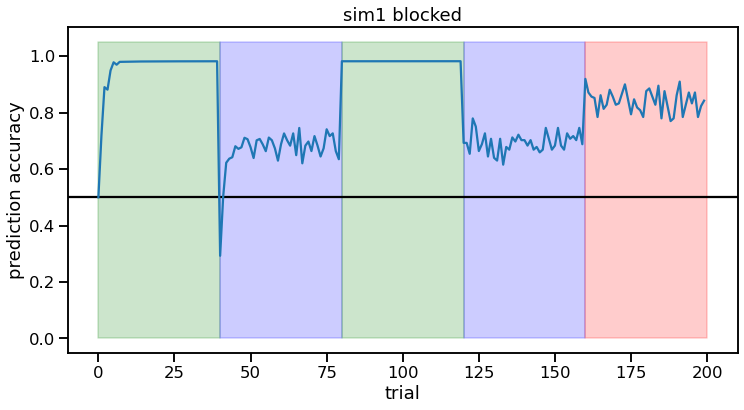

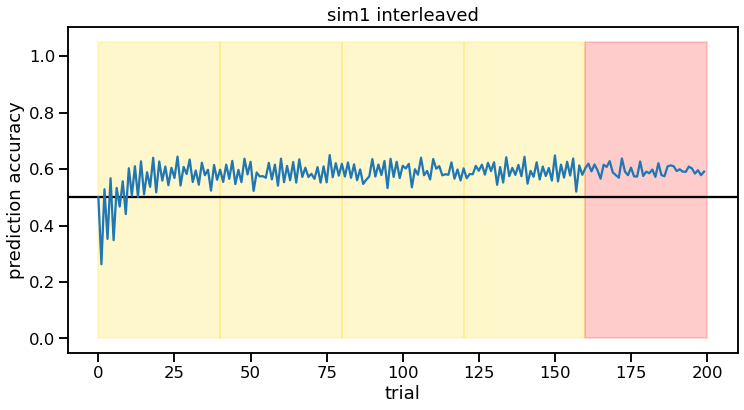

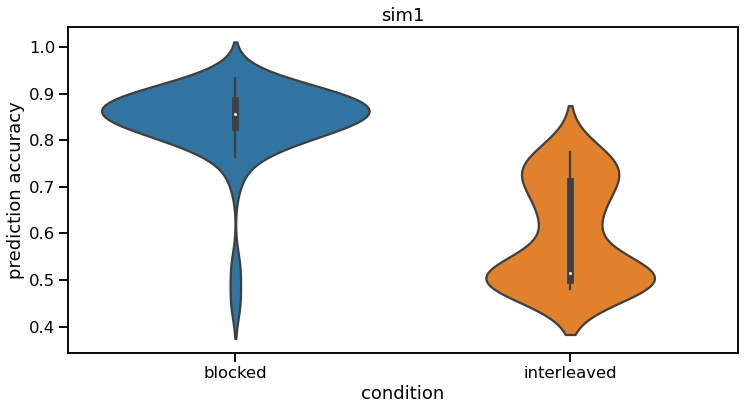

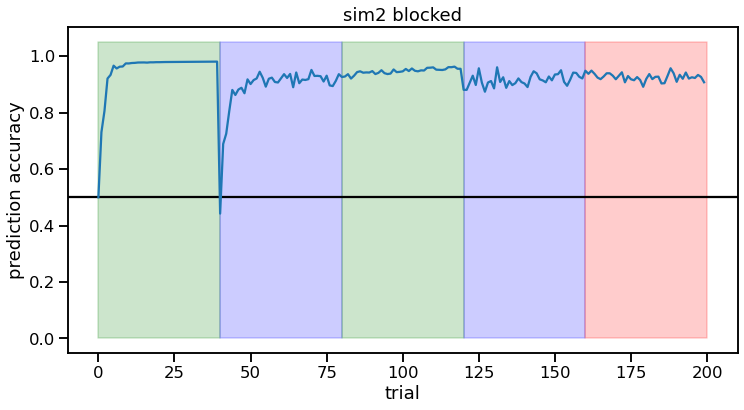

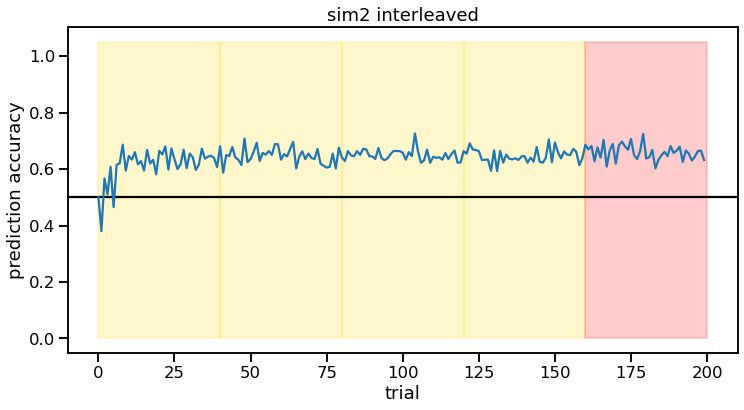

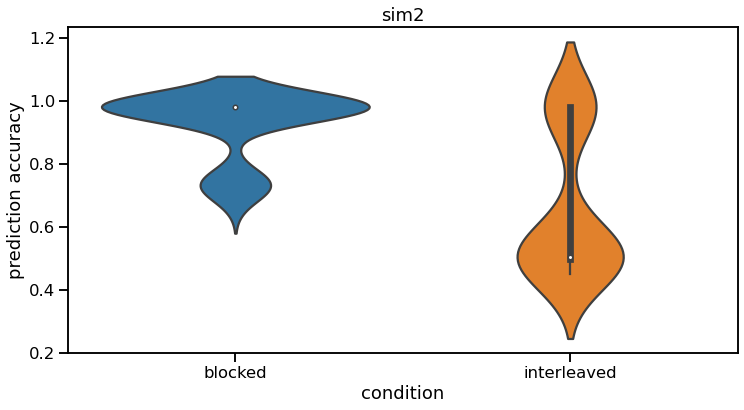

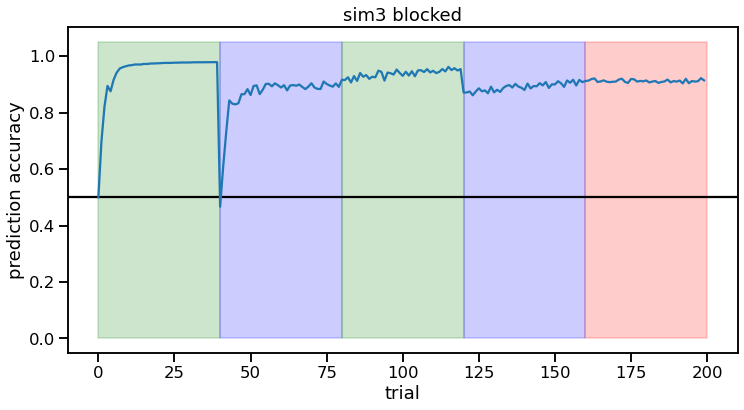

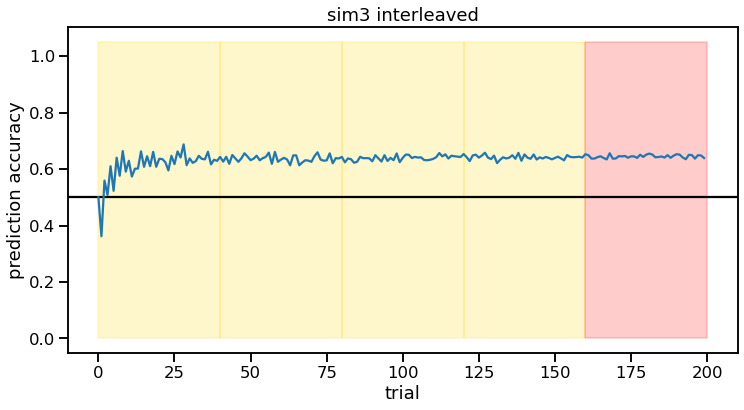

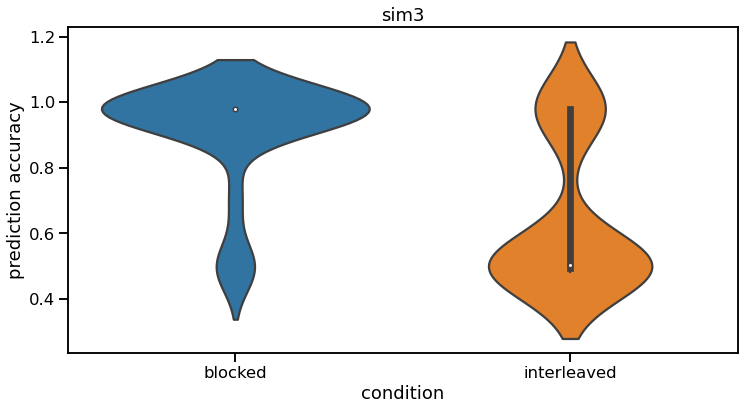

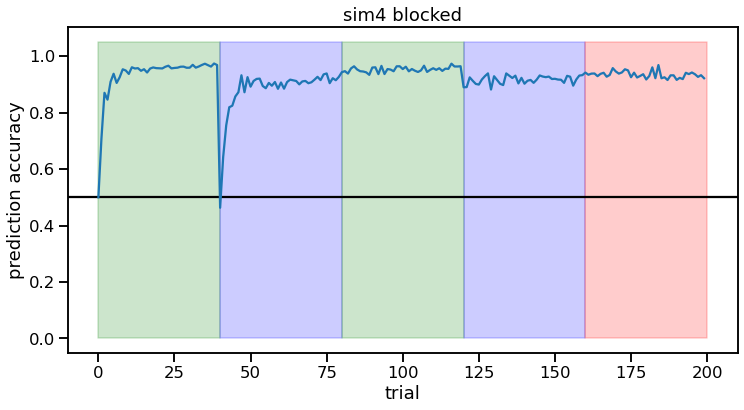

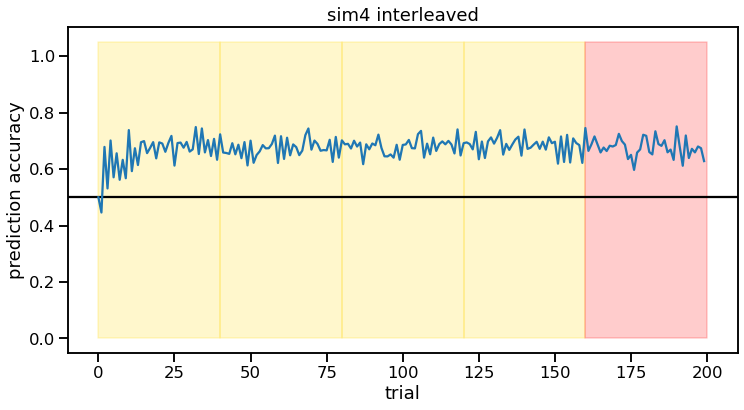

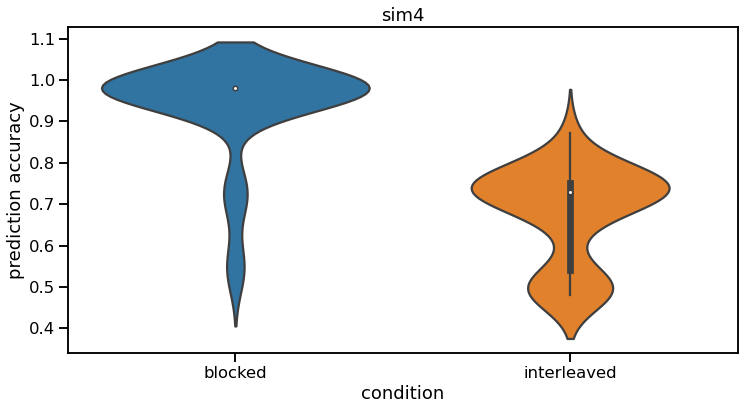

In [6]:
model_acc_df.loc[:,'cond_int'] = model_acc_df.cond
model_states_df.loc[:,'cond_int'] = model_states_df.cond
model_acc_df.cond = model_acc_df.cond.apply(lambda x: {
  0:'blocked',1:'interleaved',2:'early',3:'middle',4:'late'
}[x])
for gsname in ["sim1", "sim2", "sim3", "sim4"]:
    lineplot_modelBI(gsname)
    beeswarm_modelBI(gsname)

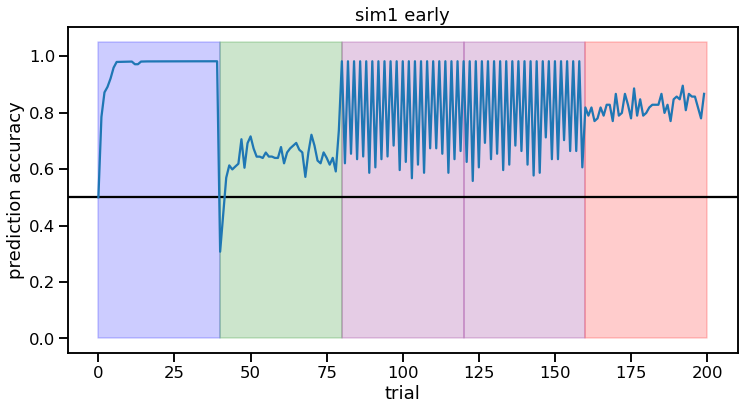

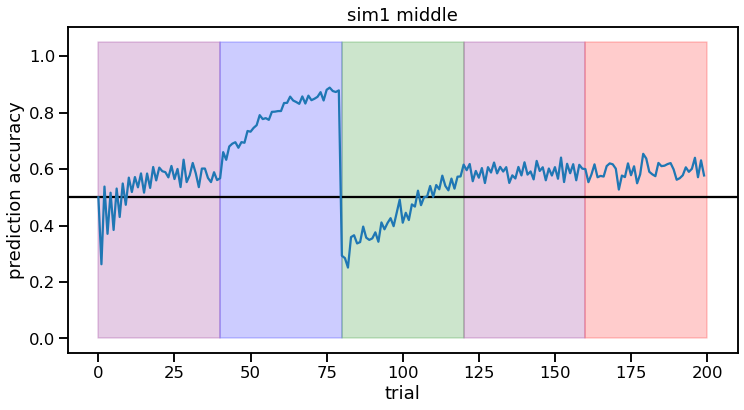

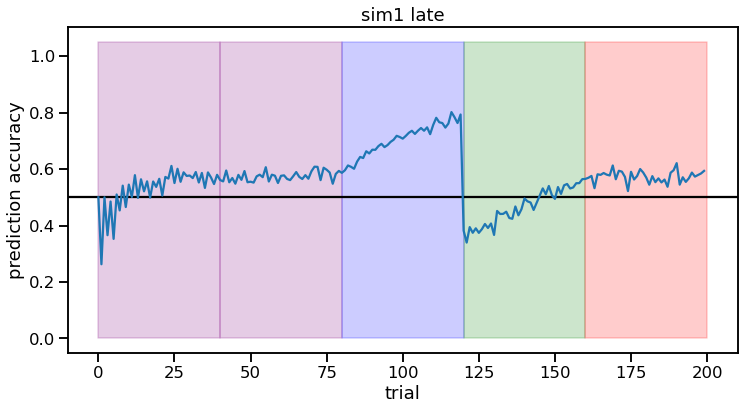

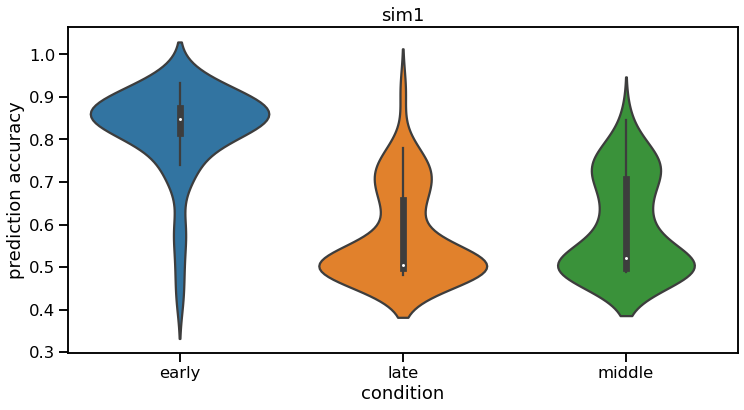

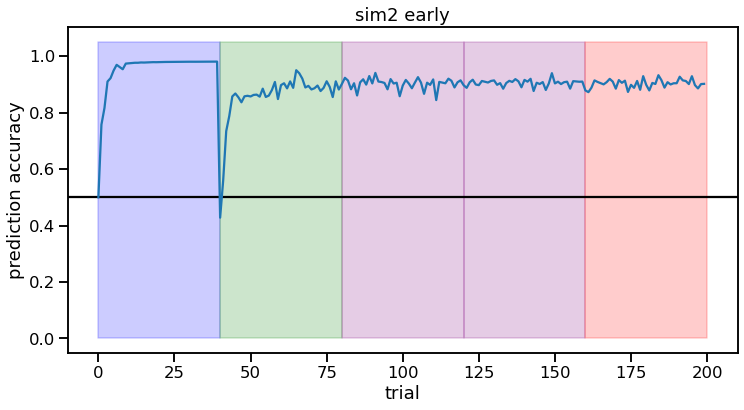

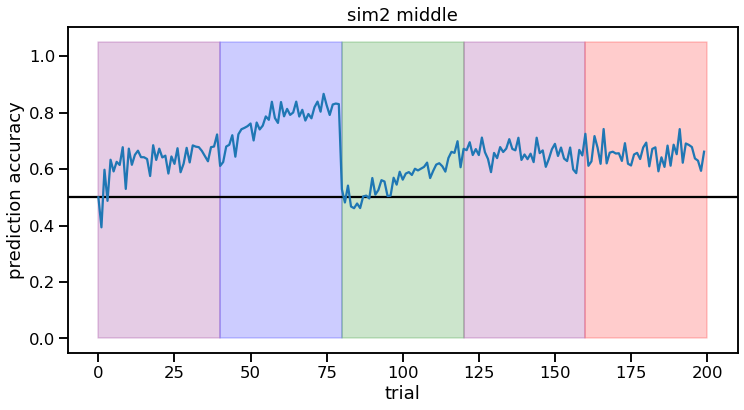

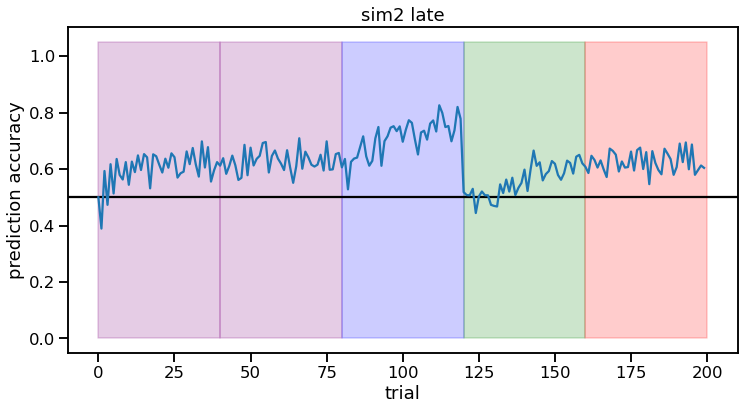

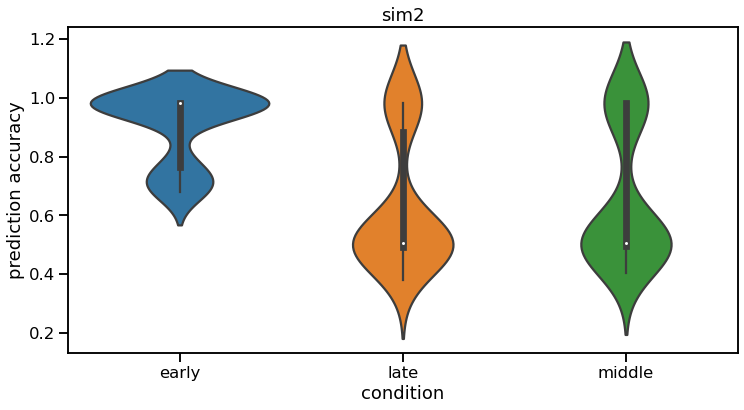

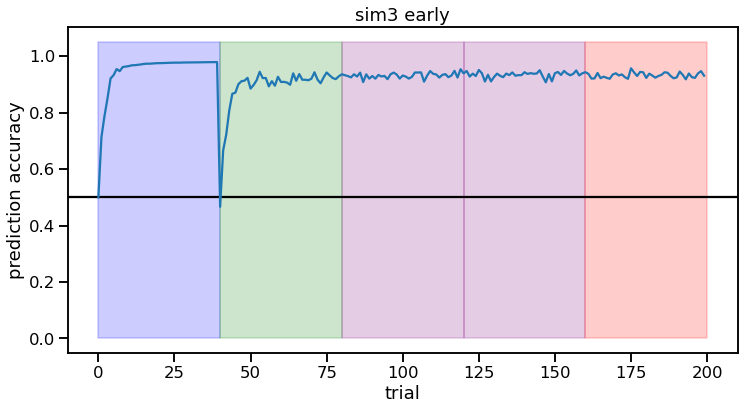

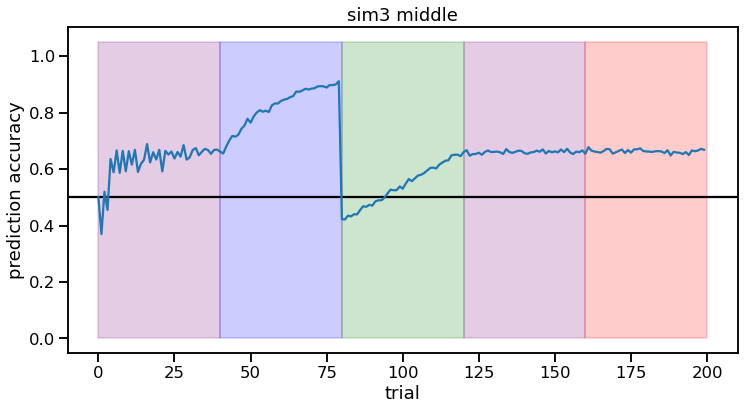

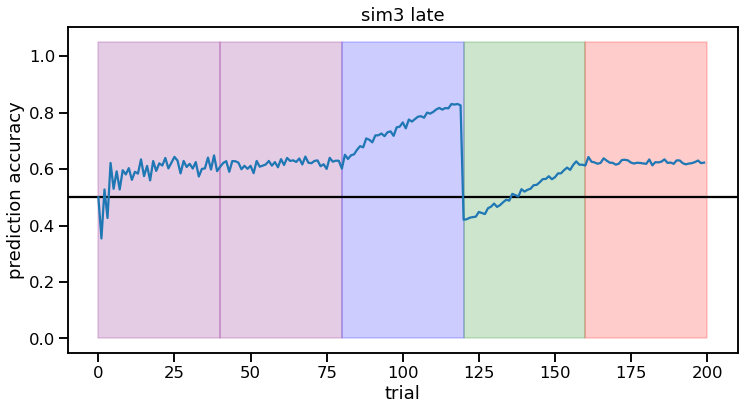

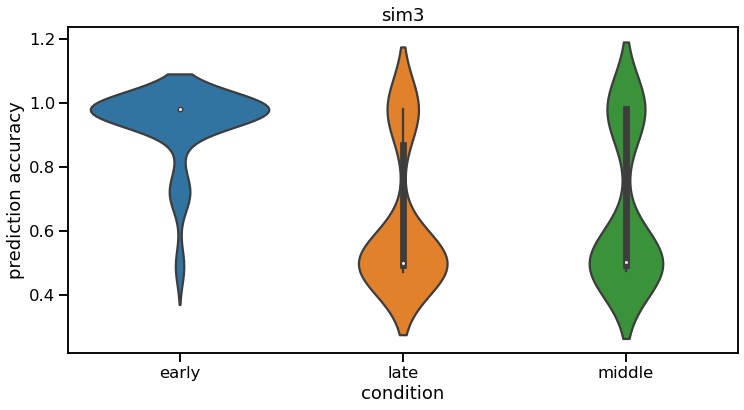

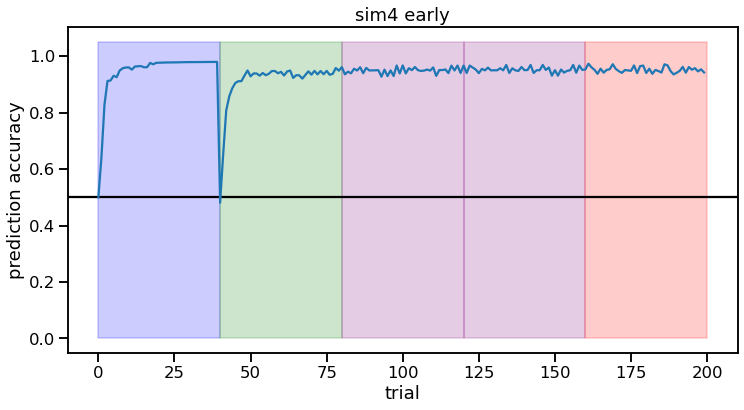

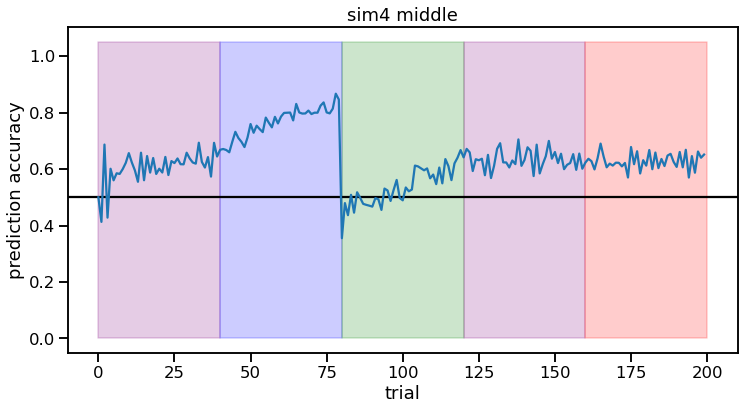

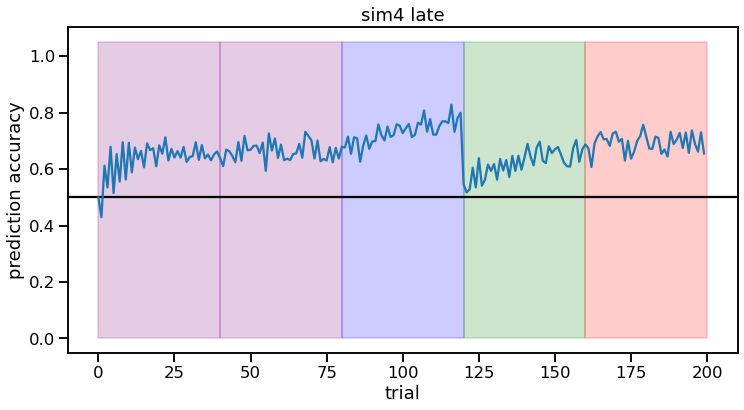

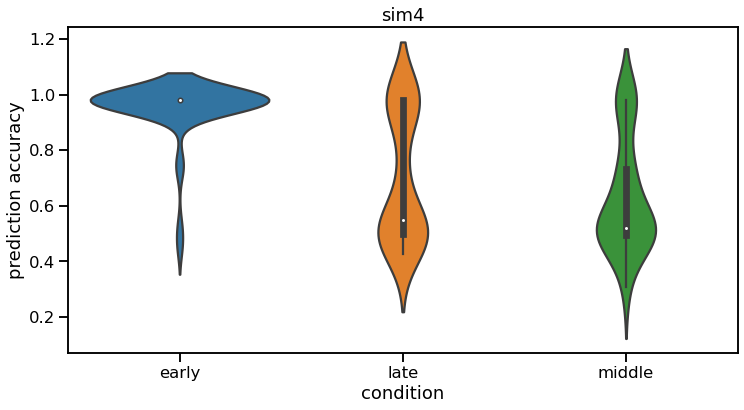

In [7]:
for gsname in ["sim1", "sim2", "sim3", "sim4"]:
    lineplot_modelEML(gsname)
    beeswarm_modelEML(gsname)